# ProperImage con DES Cluster Simulation

Vamos a ver como usamos a ProperImage para analizar la PSF de las simulaciones de **DES**.

Para eso es importante primero clonar a ProperImage:

`git clone git@github.com:toros-astro/ProperImage.git`

y luego realizar la instalacion de properimage en nuestro sistema.

Es simplemente moverse al lugar donde esta clonado, y hacer lo siguiente:


`pip install -e .`

Con esto ya podremos entrar a una terminal IPython e importar los modulos de *properimage*

In [60]:
import os

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline

#librerias propias
import psf_DES
import test_psf_DES
from properimage import single_image as si
from properimage import utils
from properimage import plot

In [2]:
from astropy.convolution import convolve

In [3]:
from astropy.nddata.utils import extract_array

## Abriendo una de las imagenes

Vamos a ver como abrir una imagen de **DES Cluster Simulation**

In [4]:
image_path = os.path.abspath('./../imagenes-LN-PSF/im_06_6.fits')

img = fits.getdata(image_path)

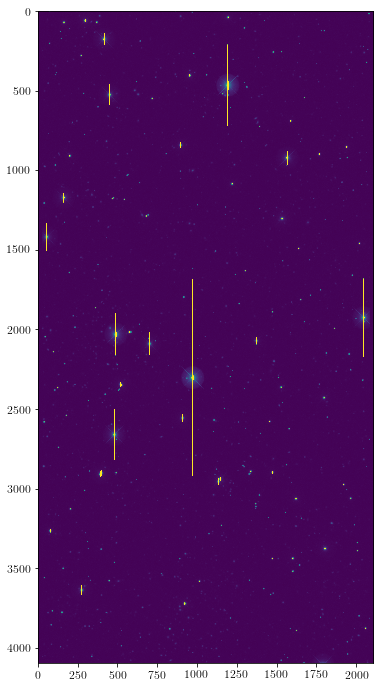

In [5]:
plt.figure(figsize=(8,12))
plt.imshow(np.log10(img), interpolation='none', cmap='viridis')

Como se puede ver la imagen es grande, y posee estrellas saturadas.

Para trabajar con ProperImage es necesario trabajar con instancias del objeto `SingleImage`.

Este objeto esta modificado mediante herencia para DES y se llama en cambio `psf_DES.SingleImageDES`.
Ademas, para trabajar con DES se deben setear parametros importantes, que se relacionan con sextractor:


In [6]:
seeing_par = {}
seeing_par['pixsize'] = 0.27
seeing_par['run'] = 33
seeing_par['filter'] = 'R'
seeing_par['magmax'] = 23.
seeing_par['magmin'] = 18.
seeing_par['fwhmmax'] = 4.5
seeing_par['plot'] = None
seeing_par['img'] = image_path

In [7]:
image = psf_DES.SingleImageDES(seeing_par=seeing_par, img=image_path)

 
 ------------ seeing:  0.84105
 ------------ imagen:  /home/bruno/Devel/DESCSimulation/imagenes-LN-PSF/im_06_6.fits
 
cantidad de estrellas seleccionadas:  223
cantidad de galaxias seleccionadas:  1568
Sources good to calculate = 223
returning best sources
stamps will be 9 x 9


## Extraer una autopsf

Realizar esta operacion es bastante simple, y solo hay un parametro que tal vez queremos modificar.
Dentro del calculo de psf se extraen parches donde estan las mejores estrellas ($P^*_i$), y se generan componentes principales, utilizando una matriz de correlacion $C_{ij} = <P^*_i, P^*_j>$.

Esta matriz genera los autovalores $\lambda_i$ y autovectores $\omega_i$.

El valor de rechazo para los autovalores se impone de forma tal que si $\Lambda = \sum\limits_{j=1} |\lambda_j|$

$1 - \sum\limits_{i=1}^k \frac{\lambda_i}{\Lambda} > \texttt{inf\_loss}$

In [8]:
a_fields, psf_basis = image.get_variable_psf(inf_loss=0.0005)

('Masked pixels: ', 25503)


Para graficar los resultados, podemos utilizar las funciones del modulo **utils** de ProperImage:

In [9]:
len(psf_basis)

11

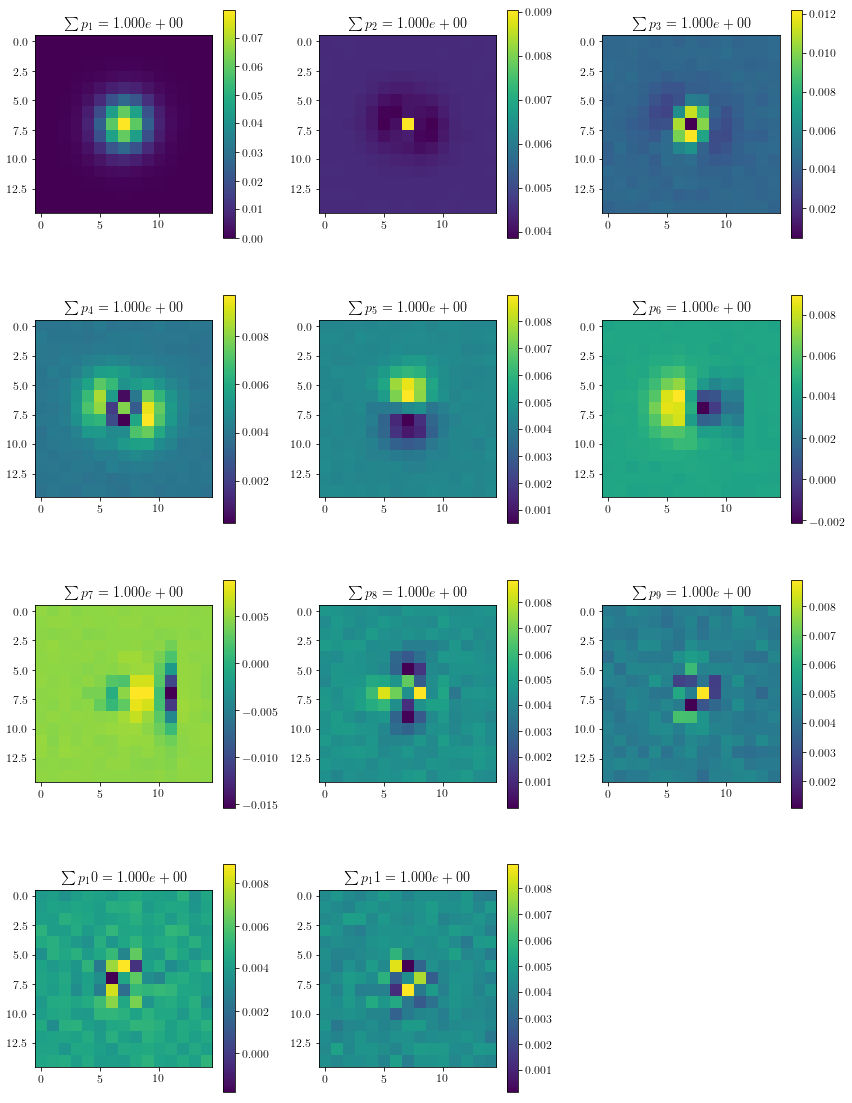

In [10]:
plot.plot_psfbasis(psf_basis=psf_basis, nbook=True)

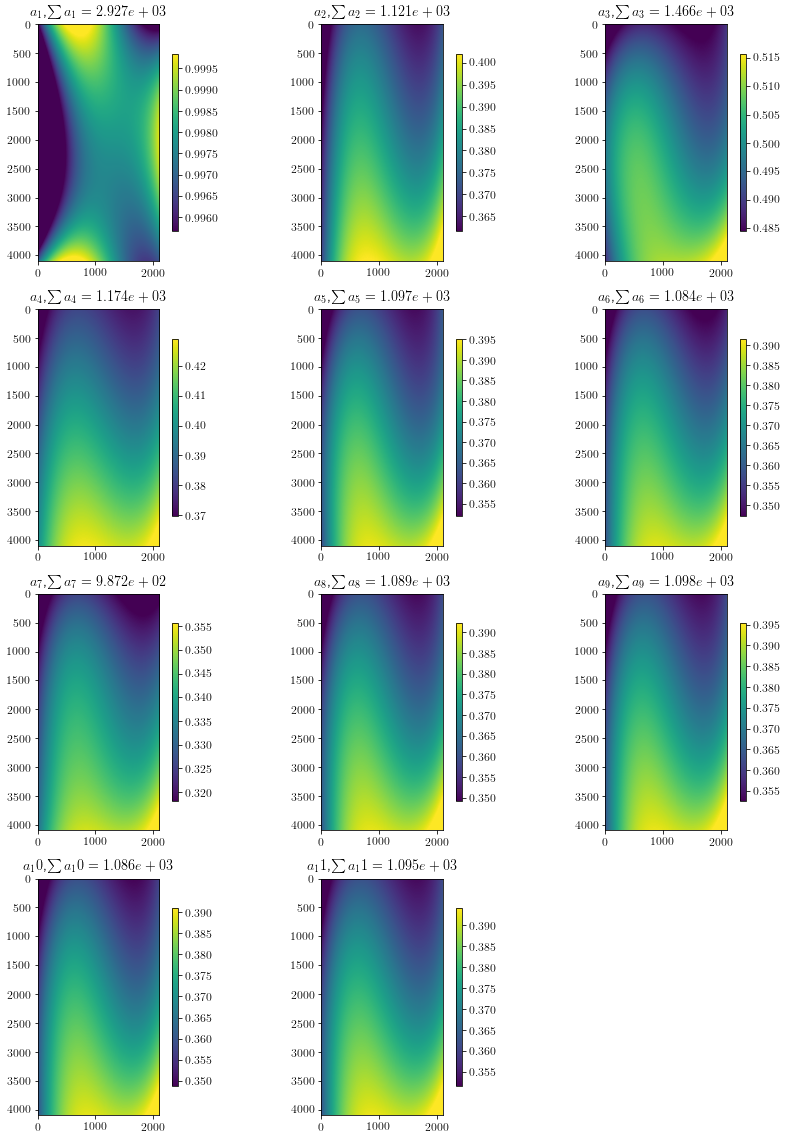

In [11]:
x, y = image.get_afield_domain()
plot.plot_afields(a_fields, x, y, nbook=True)

Como pusimos un $\texttt{pow_th}$ demasiado alto, unicamente una **psf** fue estimada.

Podemos probar con un corte mas relajado; y a la vez introducir una cualidad extra de Properimage: el **contexto**

Esto significa que si queremos limpiar los archivos adicionales que debimos calcular para la imagen anterior debemos ejecutar la siguiente celda:

In [12]:
image._clean()

cleaning... 


En cambio, esto puede ser manejado simplemente con un generador de contexto de Python:

In [13]:
image_path = os.path.abspath('./../imagenes-LN-PSF/im_06_6.fits')

In [14]:
reload(psf_DES)

<module 'psf_DES' from 'psf_DES.pyc'>

In [54]:
with psf_DES.SingleImageDES(seeing_par=seeing_par, img=image_path) as image:
    a_fields, psf_basis = image.get_variable_psf(inf_loss=0.0008)
    gxs = image.gxs

 
 ------------ seeing:  0.84105
 ------------ imagen:  /home/bruno/Devel/DESCSimulation/imagenes-LN-PSF/im_06_6.fits
 
cantidad de estrellas seleccionadas:  223
cantidad de galaxias seleccionadas:  1568
Sources good to calculate = 223
returning best sources
stamps will be 9 x 9
('Masked pixels: ', 25503)
cleaning... 


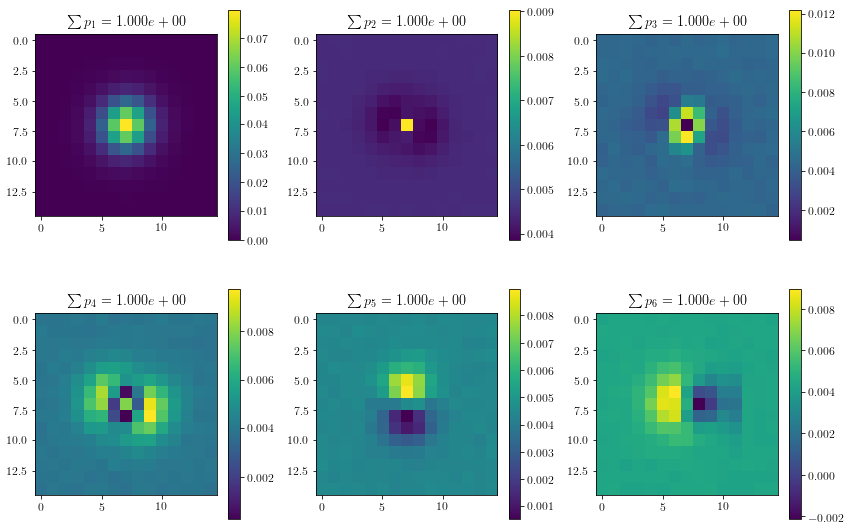

In [55]:
plot.plot_psfbasis(psf_basis=psf_basis, nbook=True)

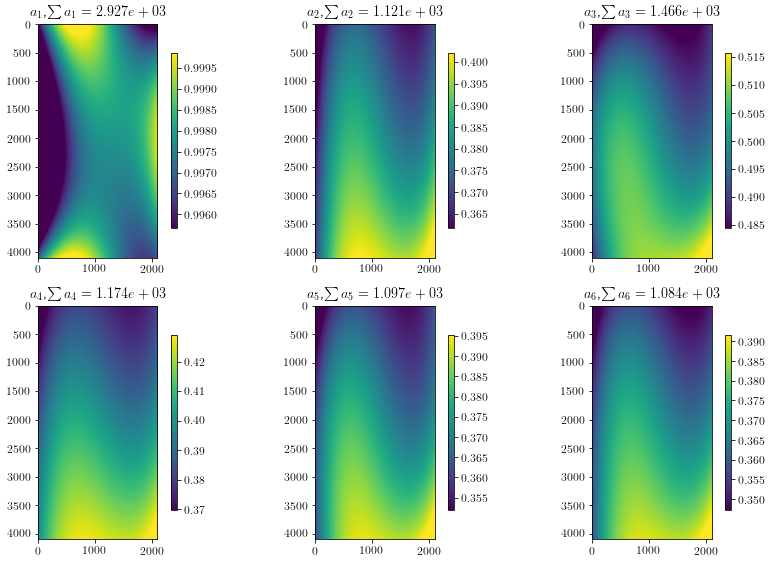

In [56]:
plot.plot_afields(a_fields, x, y, nbook=True)

In [57]:
from astropy.modeling import models, fitting
def get_single_psf(x, y, a_fields, psf_basis):
    s = np.zeros_like(psf_basis[0])
    
    for i in range(len(psf_basis)):
        s += psf_basis[i]*a_fields[i](x,y)
    
    x, y = np.mgrid[:s.shape[0], :s.shape[1]]
    g2 = models.Gaussian2D(x_stddev=1, y_stddev=1, 
                           x_mean=s.shape[0]/2, 
                           y_mean=s.shape[1]/2)
    fitter = fitting.LevMarLSQFitter()
    
    return fitter(g2, x, y, s) 
        

In [58]:
p = get_single_psf(1115, 2145, a_fields, psf_basis)

In [59]:
p

<Gaussian2D(amplitude=0.06583571882651358, x_mean=6.95857244085753, y_mean=6.950563151195477, x_stddev=2.1676601847982213, y_stddev=2.070848914366892, theta=-3.396609012565039)>

In [22]:
from astropy.io import ascii
from astropy.table import Table, Row

In [28]:
class MyHeader(ascii.BaseHeader):
    start_line = 3
    
class MyWriter(ascii.)


In [23]:
def write_im2shape_psftab(table, filepath):
    with open(filepath, 'w') as f:
        f.write('1\n')
        f.write(str(len(gxs)) + '\n')
        f.write('6\n')
        table.write(f, format='ascii.csv')

In [24]:
def write_im2shape_gxstab(table, filepath):
    with open(filepath, 'w') as f:
        f.write('26 '+str(len(table)) + '\n')
        table.write(f, format='ascii.csv')

In [25]:
write_im2shape_psftab(table=gxs, filepath='prueba_im2shape.csv')

In [26]:
write_im2shape_gxstab(table=gxs, filepath='prueba_im2shape_gxs.csv')

In [27]:
!cat prueba_im2shape_gxs.csv

26 1568
NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,A_IMAGE,B_IMAGE,THETA_IMAGE,ERRA_IMAGE,ERRB_IMAGE,ERRTHETA_IMAGE,MAG_BEST,MAGERR_BEST,MAG_ISO,MAGERR_ISO,MAG_APER,MAGERR_APER,MAG_AUTO,MAGERR_AUTO,ISOAREA_IMAGE,FWHM_IMAGE,FLUX_RADIUS,FLUX_MAX,MU_MAX,CLASS_STAR,FLAGS
5,60.15,61.3345,336.7387261,-32.8218644,4.66,2.916,77.74,0.07422,0.0452,77.76,16.8638,0.0166,16.9515,0.0141,17.5347,0.0152,16.8638,0.0166,221,10.78,4.696,112.5756,18.7582,0.016,0
6,893.6801,39.0539,336.7407208,-32.7593617,4.495,4.067,-87.64,0.01917,0.01732,88.26,14.6378,0.0036,14.6409,0.0036,15.1868,0.004,14.6378,0.0036,559,7.27,4.214,989.6073,16.3982,0.03,0
7,386.9497,37.0085,336.7408994,-32.7973595,4.048,3.732,4.63,0.01527,0.01427,10.21,14.52,0.0033,14.5182,0.0033,14.9628,0.0035,14.52,0.0033,493,6.71,3.833,1329.703,16.0774,0.03,0
8,1451.0759,39.2111,336.740711,-32.7175639,2.824,2.707,-70.45,0.06348,0.06028,-76.42,17.6052,0.025,17.6957,0.0202,17.893,0.0195,17.6052,0.025,110,6.93,3.402,95.1673,18.9406,0.019,0
9,576.252

In [32]:
gxs.write('galaxias_im06_6.cat', format='ascii.no_header', overwrite=True)

In [30]:
lines = []
for row in gxs:
    p = get_single_psf(row['X_IMAGE'], row['Y_IMAGE'], a_fields, psf_basis)
    sx = p.x_stddev
    sy = p.y_stddev
    th = p.theta
    
    a = 2*max([sx, sy])
    b = 2*min([sx, sy])
    
    ellip = (a - b)/float(a + b)
    
    lines.append([row['X_IMAGE'], row['Y_IMAGE'], 0., 0., ellip, th-np.pi/4., a*b, 1.])
    

PSFs = Table(rows=lines, names=('x', 'y', 'zero1', 'zero2', 'ellip', 'theta', 'a_times_b', 'one'))'galaxias_im06_6.cat'

In [31]:
PSFs.write('PSFS_im06_6.dat', format='ascii.tab')

In [33]:
float(a-b)/float(a+b)

0.014373731280584508

In [34]:
len(PSFs)

1568

In [42]:
reload(utils)

<module 'properimage.utils' from '/home/bruno/Devel/zackay_code/properimage/properimage/utils.py'>

In [45]:
%%time
deconvolved = utils.lucy_rich(img, psf_basis, a_fields, adomain=image.get_afield_domain(), clip=True, iterations=5)

CPU times: user 17min 24s, sys: 45.4 s, total: 18min 9s
Wall time: 18min 12s


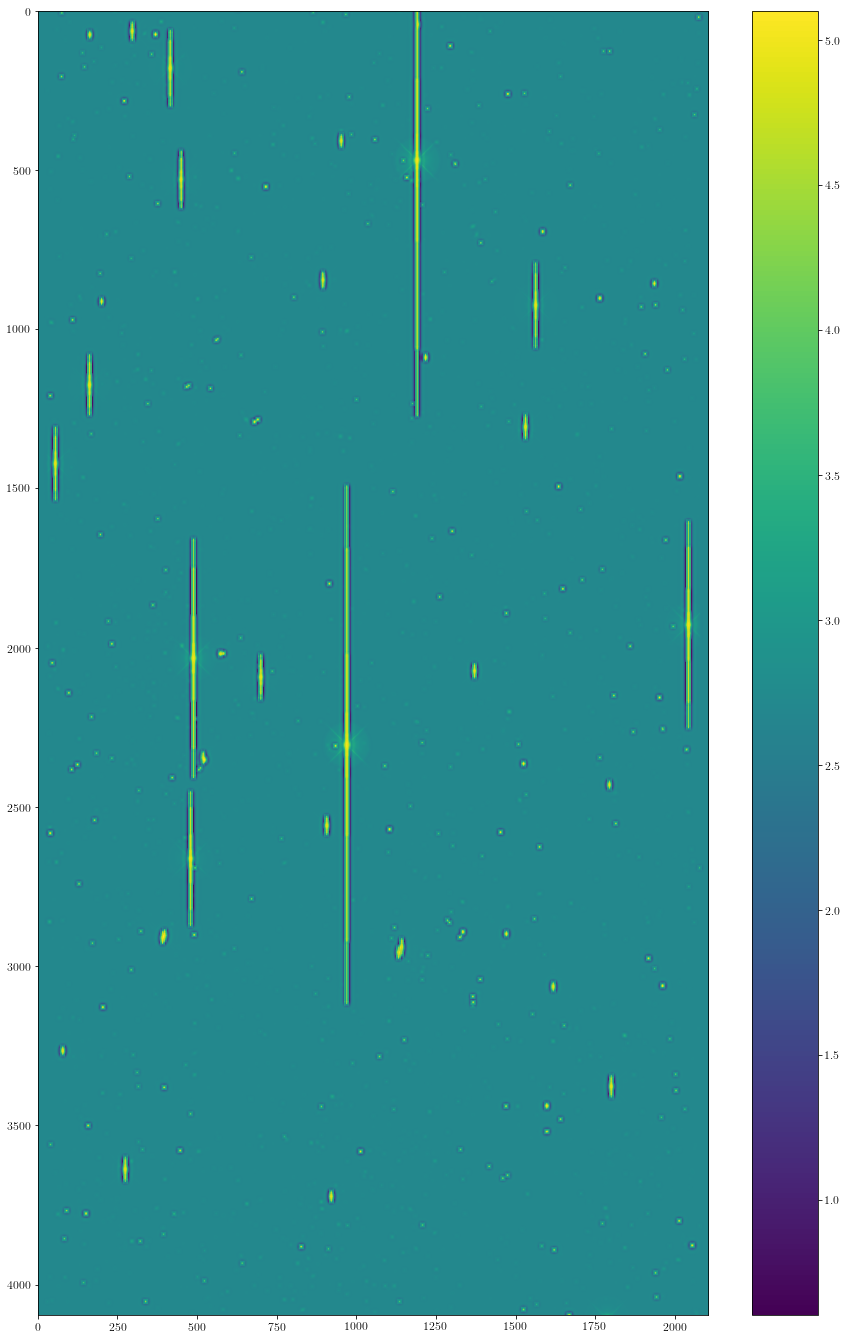

In [46]:
plt.figure(figsize=(16, 24))
plt.imshow(np.log10(deconvolved), interpolation='none', cmap='viridis')
plt.colorbar()

In [48]:
%%time
deconvolved10 = utils.lucy_rich(img, psf_basis, a_fields, adomain=image.get_afield_domain(), 
                                clip=True, iterations=10)

CPU times: user 33min 16s, sys: 1min 21s, total: 34min 37s
Wall time: 34min 38s


In [49]:
%%time
deconvolved15 = utils.lucy_rich(img, psf_basis, a_fields, adomain=image.get_afield_domain(), 
                                clip=True, iterations=15)

KeyboardInterrupt: 

In [ ]:
%%time
deconvolved20 = utils.lucy_rich(img, psf_basis, a_fields, adomain=image.get_afield_domain(), 
                                clip=True, iterations=20)

In [ ]:
%%time
deconvolved25 = utils.lucy_rich(img, psf_basis, a_fields, adomain=image.get_afield_domain(), 
                                clip=True, iterations=25)

In [ ]:
%%time
deconvolved50 = utils.lucy_rich(img, psf_basis, a_fields, adomain=image.get_afield_domain(), 
                                clip=True, iterations=50)

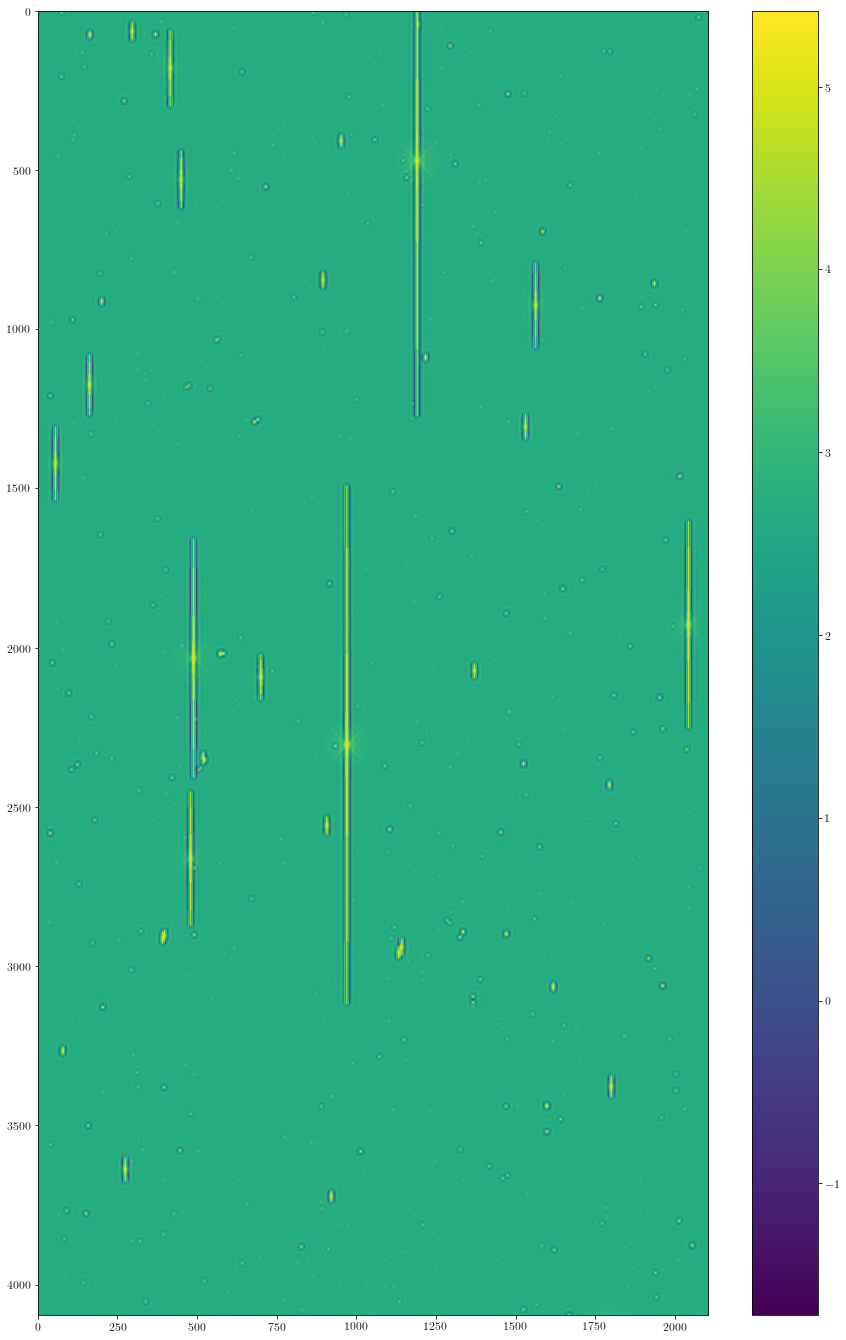

In [50]:
plt.figure(figsize=(16, 24))
plt.imshow(np.log10(deconvolved10), interpolation='none', cmap='viridis')
plt.colorbar()

In [ ]:
a = np.zeros_like(img)


In [ ]:
for x_i in range(100, 3800, 300):
    for y_i in range(100, 2000, 300):
        a[x_i, y_i] = 1. 

In [ ]:
x, y = np.mgrid[:img.shape[0], :img.shape[1]]

In [ ]:
rebuild = np.zeros_like(a)

for k in range(len(psf_basis)):
    rebuild = rebuild + convolve(a, psf_basis[k])* a_fields[k](x, y)

rebuild += 10.

In [ ]:
patches = []
for x_i in range(100, 3800, 300):
    for y_i in range(100, 2000, 300):
        position = [x_i, y_i+1]
        patch = np.log10(extract_array(rebuild, (12, 12), position))
        patches.append(patch)

In [ ]:
patches.reverse()
plot.plot_psfbasis(psf_basis=patches, nbook=True)